# Evaluate model

## DenseUnet

In [4]:
def calc_metrics (gt, pred, heading): 
    diff = gt - (pred *2)
    fn = (diff== 1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff== 0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    # work out IoU
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return(fn, tp, fp, tn, np.round(100*p,2), np.round(100*r,2), np.round(100*f1,2), iou_score)

def output(predictions, test_dl, test_files):
    tot_fn = tot_tp = tot_fp = tot_tn = tot_p = tot_r = tot_f1 = 0
    for index, item in enumerate(predictions[0]):
        y_hat = array(predictions[0][index].argmax(dim=0))
        y_true = array(test_dl.dataset[index][1])
        fn, tp, fp, tn, p, r, f1, iou = calc_metrics(y_true, y_hat, str(test_files[index]))
        #print(tot_fn, tot_tp, tot_fp, tot_tn, tot_p, tot_r, tot_f1)
        tot_fn += fn
        tot_tp += tp
        tot_fp += fp
        tot_tn += tn
        tot_p += p
        tot_r += r
        tot_f1 += f1
    return(tot_p, tot_r, tot_f1, iou)

In [5]:
%matplotlib inline

In [6]:
from fastai.vision.all import *
#hide
from fastbook import *

In [9]:
#path = Path("../data/usq/mra_mip")
#path = Path("../data/usq/imageprojections/test2/images")
path = Path("../data/usq/imageprojections/p1/images")

In [10]:
#get_y = lambda o: get_msk(o)
def get_y(o):
    return get_msk(o)

def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [25]:
#img_size = (320, 320) # p1
#img_size = (247, 320) # p2/p3
#img_size = (247, 639) #p4/p5
img_size = (320, 566) #p6/p7/p8/p9

In [20]:
codes = ['Background', 'CV']


dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(img_size))#, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   #batch_tfms=[Normalize.from_stats(*imagenet_stats)])

dsets = dblock.datasets(path)    
dls = dblock.dataloaders(path, bs=1)
#dls = dblock.dataloaders(path, bs=8)
dls.vocab = codes

import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

encoder = nn.Sequential(*list(models.densenet121().children())[0])
unet = DynamicUnet(encoder, n_classes=2, img_size=img_size, blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)
#weights = torch.tensor([[0.5] + [1.5]]).cuda()
weights = torch.tensor([[0.5] + [2.5]]).cuda()

loss_func = CrossEntropyLossFlat(weight=weights, axis=1)
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])

#learn = Learner(dls, unet, metrics=[foreground_acc, Dice()])

    sn        layer     c    w    h               size
2    2         ReLU    64  124  160  (1, 64, 124, 160)
4    4  _DenseBlock   256   62   80   (1, 256, 62, 80)
6    6  _DenseBlock   512   31   40   (1, 512, 31, 40)
8    8  _DenseBlock  1024   15   20  (1, 1024, 15, 20)
11  11  BatchNorm2d  1024    7   10   (1, 1024, 7, 10)


In [17]:
def score(projections):
    for i in projections:
        #learn = load_learner(f'../src/dense_unet_mip_images_model_p{i}.pkl')
        learn = load_learner(f'dense_unet_mip_images_model_p{i}.pkl')
        path = Path(f'../data/usq/imageprojections/p{i}/images')
        test_files = get_image_files(path) 
        test_dl = learn.dls.test_dl(test_files, with_labels=True)
        
        preds = learn.get_preds(dl=test_dl)
        #torch.save((preds[0]), f'../data/usq/results/{i}.pt')
        print(f'Results for {i}:')
        precision, recall, f1, iou = output(preds, test_dl, test_files)
        print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])} IoU: {iou}')    

In [18]:
# trained on all imageprojections (320, 320)
score([1])

Results for 1:
Precision: 89.12222222222222 Recall: 82.18666666666667 F1 Score: 74.86333333333333 IoU: 0.7388351207603104


In [22]:
# trained on all imageprojections (247, 320)
score([2,3])

Results for 2:
Precision: 84.43555555555555 Recall: 84.53888888888888 F1 Score: 78.97333333333333 IoU: 0.8264666960741068


Results for 3:
Precision: 81.80000000000001 Recall: 85.82777777777778 F1 Score: 77.91444444444444 IoU: 0.7844504808751193


In [24]:
# trained on all imageprojections (247, 639)
score([4,5])

Results for 4:
Precision: 82.16333333333334 Recall: 88.03777777777779 F1 Score: 78.81888888888889 IoU: 0.8377140752562764


Results for 5:
Precision: 81.27555555555556 Recall: 89.52444444444444 F1 Score: 78.95777777777776 IoU: 0.8301721622410271


In [26]:
# trained on all imageprojections (247, 639)
score([6, 7, 8, 9])

Results for 6:
Precision: 83.60777777777778 Recall: 83.35 F1 Score: 77.7811111111111 IoU: 0.8276926908230607


Results for 7:
Precision: 84.78444444444443 Recall: 81.04444444444442 F1 Score: 77.40222222222222 IoU: 0.8014283421601669


Results for 8:
Precision: 84.85000000000001 Recall: 83.68333333333334 F1 Score: 78.65555555555557 IoU: 0.8220828336869293


Results for 9:
Precision: 81.33555555555554 Recall: 82.65888888888887 F1 Score: 76.09555555555556 IoU: 0.8237096673531798


In [ ]:
def score(mra):
    for i in mra:
        #learn = load_learner(f'../src/dense_unet_mip_images_model_p{i}.pkl')
        learn = load_learner(f'dense_unet_mip_images_model_p{i}.pkl')
        path = Path(f'../data/usq/imageprojections/p{i}/images')
        test_files = get_image_files(path) 
        test_dl = learn.dls.test_dl(test_files, with_labels=True)
        
        preds = learn.get_preds(dl=test_dl)
        #torch.save((preds[0]), f'../data/usq/results/{i}.pt')
        print(f'Results for {i}:')
        precision, recall, f1, iou = output(preds, test_dl, test_files)
        print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])} IoU: {iou}')    

In [74]:
#path = Path("../data/usq/imageprojections/all/images")
path = Path("../data/usq/imageprojections/test7/images")

In [75]:
cv_items = get_image_files(path)
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)

tfms = [[PILImage.create], [get_y, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer((640, 640)), ToTensor(), IntToFloatTensor()])

In [85]:
dsets = dblock.datasets(path)

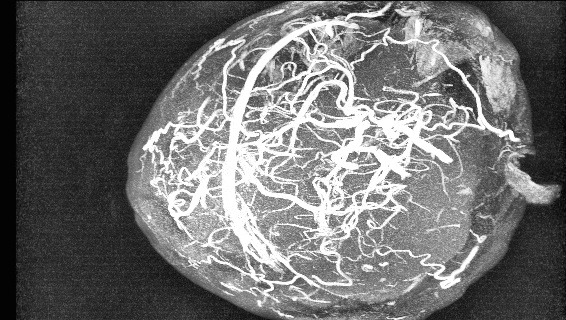

In [86]:
dsets.train[0][0]

## Evaluate per MRA dataset

In [20]:
def output(predictions, test_dl, test_files):
    tot_fn = tot_tp = tot_fp = tot_tn = tot_p = tot_r = tot_f1 = 0
    for index, item in enumerate(predictions[0]):
        y_hat = array(predictions[0][index].argmax(dim=0))
        y_true = array(test_dl.dataset[index][1])
        fn, tp, fp, tn, p, r, f1, iou = calc_metrics(y_true, y_hat, str(test_files[index]), True)
        #print(tot_fn, tot_tp, tot_fp, tot_tn, tot_p, tot_r, tot_f1)
        tot_fn += fn
        tot_tp += tp
        tot_fp += fp
        tot_tn += tn
        tot_p += p
        tot_r += r
        tot_f1 += f1
    return(tot_p, tot_r, tot_f1, iou)

In [13]:
def one_off(mra):
    for i in mra:
        path = Path(f'../data/usq/oneoff/{i}/images')
        test_files = get_image_files(path) 
        test_dl = learn.dls.test_dl(test_files, with_labels=True)
        preds = learn.get_preds(dl=test_dl)
        torch.save((preds[0]), f'../data/usq/results/{i}.pt')
        print(f'Results for {i}:')
        precision, recall, f1, iou = output(preds, test_dl, test_files)
        print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])} IoU: {iou}')

In [14]:
one_off(['MNI_0590', 'MNI_0591', 'MNI_0592', 'MNI_0640', 'MNI_0643', 'MNI_0648', 'MNI_0656', 'MNI_0657', 'MNI_0663'])

Results for MNI_0590:
Precision: 81.3402024291498 Recall: 89.81165991902837 F1 Score: 82.34939271255062 IoU: 0.3839124839124839


Results for MNI_0591:
Precision: 80.70506072874493 Recall: 89.26149797570847 F1 Score: 81.44234817813765 IoU: 0.7646307477937762


Results for MNI_0592:
Precision: 80.62461538461535 Recall: 89.90692307692314 F1 Score: 81.73020242914983 IoU: 0.862007623888183


Results for MNI_0640:
Precision: 80.93902834008095 Recall: 89.29149797570844 F1 Score: 81.81805668016187 IoU: 0.8334284084426697


Results for MNI_0643:
Precision: 81.8521862348178 Recall: 89.81659919028341 F1 Score: 82.58182186234814 IoU: 0.11893484896326703


Results for MNI_0648:
Precision: 82.34700404858299 Recall: 90.75493927125511 F1 Score: 83.48267206477743 IoU: 0.73138784551671


Results for MNI_0656:
Precision: 85.11882591093114 Recall: 92.6270850202429 F1 Score: 86.4451821862348 IoU: 0.8548408400475499


Results for MNI_0657:
Precision: 81.84340080971664 Recall: 91.30975708502025 F1 Score: 83.62781376518217 IoU: 0.8527705898099402


Results for MNI_0663:
Precision: 83.95485829959514 Recall: 93.43599190283402 F1 Score: 85.90497975708504 IoU: 0.8441706593657312


In [291]:
# just run results
def just_results(mra):
    for i in mra:
        path = Path(f'../data/usq/oneoff/{i}/images')
        test_files = get_image_files(path) 
        test_dl = learn.dls.test_dl(test_files, with_labels=True)
        preds = torch.load(f'../data/usq/results/{i}.pt')
        print(f'Results for {i}:')
        precision, recall, f1 = output(preds, test_dl, test_files)
        print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])}')

In [293]:
just_results(['MNI_0592'])

Results for MNI_0592:
Precision: nan Recall: nan F1 Score: nan


In [294]:
preds = torch.load(f'../data/usq/results/MNI_0592.pt')

In [91]:
path = Path(f'../data/usq/oneoff/MNI_0592/images')
test_files = get_image_files(path) 
test_dl = learn.dls.test_dl(test_files, with_labels=True)
#preds = learn.get_preds(dl=test_dl)
preds = torch.load(f'../data/usq/results/MNI_0592.pt')
precision, recall, f1, iou = output(preds, test_dl, test_files)
print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])}')

Precision: nan Recall: nan F1 Score: nan


In [271]:
path = Path(f'../data/usq/oneoff/MNI_0592/images')
test_files = get_image_files(path) 
test_dl = learn.dls.test_dl(test_files, with_labels=True)
preds = learn.get_preds(dl=test_dl)
precision, recall, f1 = output(preds)
print(f'Precision: {precision/len(preds[0])} Recall: {recall/len(preds[0])} F1 Score: {f1/len(preds[0])}')

In [288]:
# save preds
path = Path(f'../data/usq/results/')
os.makedirs(path, exist_ok=True)
torch.save((preds[0]), path / 'MNI_0592.pt')

In [308]:
y_hat = array(preds[0][0].argmax(dim=0))
y_true = array(test_dl.dataset[0][1])

In [309]:
y_hat.shape

(320,)

In [311]:
y_true.shape

(320, 320)

In [23]:
#pred_dir = '../data/usq/oneoff/MNI_0592/masks'
pred_dir = '../data/usq/oneoff/MNI_0592/masks'
src_dir = '../data/usq/original_mra/MNI_0592'
gt_dir = '../data/usq/manual_segmentation/MNI_0592'

In [12]:
fnames = os.listdir(img_dir)
sample_3d = load_images(img_dir, fnames, len(fnames), 320, 320)

In [19]:
l_src_map = np.ndarray(shape=(1, 247, 320, 320), dtype=np.uint16)  
l_seg_map = np.ndarray(shape=(1, 247, 320, 320), dtype=np.uint16)  
l_gt_map  = np.ndarray(shape=(1, 247, 320, 320), dtype=np.uint16)  